In [23]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import einops
from types import SimpleNamespace
from sklearn.metrics import average_precision_score
from datasets import load_dataset, Audio
from timm.optim import Adan
from fastprogress import master_bar, progress_bar
from torchvision.transforms.v2 import RandomCrop, CenterCrop, CutMix, MixUp
from IPython.display import display, HTML
from tft.aug import crop_1d
from tft.transforms import strfft

In [2]:
torch.set_float32_matmul_precision('high')
device="cuda:3"
dataset = load_dataset("danjacobellis/esc_50").cast_column('opus', Audio(decode=False))

README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [33]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset['train'].num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/256)*2e-2
config.lr_pow = 1.0
config.plot_update = 8
config.epochs = 10000
config.steps = config.epochs*config.steps_per_epoch

config.weight_decay = 0.
config.num_workers = 24
config.crop_size = 1024*256

# model config
config.channels = 1
config.classifier_num_classes = 50
config.checkpoint=False

In [34]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh

class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

model = EfficientVitLarge(
    in_chans=3*config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)

model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)

model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

49.613138
0.019488 	 stem
38.017792 	 stages
11.575858 	 head


In [221]:
mix_transforms = [
    CutMix(num_classes=config.classifier_num_classes, alpha=1.),
    MixUp(num_classes=config.classifier_num_classes, alpha=1.)
]
cent_crop = CenterCrop(
    size=(1,config.crop_size),
)
def compand(x, eps=0.1):
    return x.sign() * ((x.abs()+eps)**0.4 - eps**0.4)
def decompand(y, eps=0.1):
    return y.sign() * ((y.abs()+eps**0.4)**2.5 - eps)
def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, 1, config.crop_size), dtype=torch.float)
    y = []
    for i_sample, sample in enumerate(batch):
        y.append(sample['label'])
        xi, fs = torchaudio.load(uri = sample['opus']['bytes'],normalize=False)
        xi = crop_1d(xi,config.crop_size,batch=False).unsqueeze(0)
        x[i_sample,:,:,:] = xi
    return x[:,:,0,:], torch.tensor(y).to(torch.long)

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, 1, config.crop_size), dtype=torch.float)
    y = []
    for i_sample, sample in enumerate(batch):
        y.append(sample['label'])
        xi, fs = torchaudio.load(uri = sample['opus']['bytes'],normalize=False)
        xi = cent_crop(xi.unsqueeze(0).unsqueeze(0))
        x[i_sample,:,:,:] = xi
    return x[:,:,0,:], torch.tensor(y).to(torch.long)

In [222]:
optimizer = Adan(
    params=model.parameters(),
    lr=1.0,
    weight_decay=config.weight_decay,
    caution=True
)
def rc_sched(i_step, config):
    t = i_step / (config.steps / config.plot_update)
    return config.max_lr*0.5 * (1 - np.cos(2*np.pi*(t**config.lr_pow))) + 1e-15
    return lr
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: rc_sched(i_step, config),
)

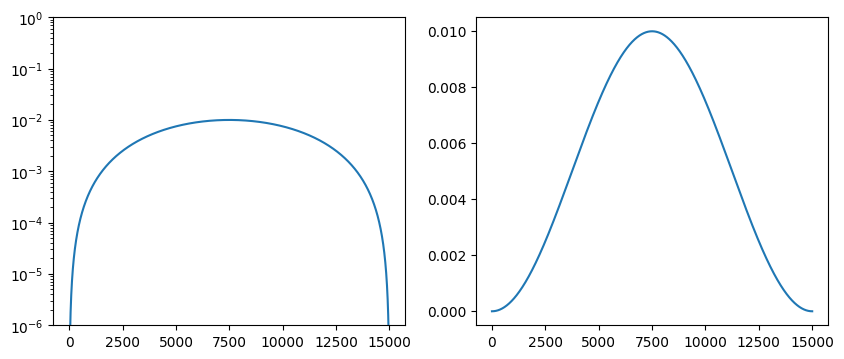

In [37]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
# axes[0].semilogy(learning_rates);axes[0].set_ylim([1e-6, 1.0])
# axes[1].plot(learning_rates);

In [363]:
i = 17
S, size_info = strfft(x); S = S[:,:,:,:-1]
S = torch.cat([S.real, S.imag, S.abs()],dim=1)
S = compand(S)
S[:,:2] = S[:,:2]/20; S[:,2] = S[:,2]/10
img0 = ToPILImage()(S[i][0]+0.5)
img1 = ToPILImage()(S[i][1]+0.5)

img0 = img0.resize((img0.width//2,img0.height//2),resample=PIL.Image.Resampling.LANCZOS).resize((img0.width,img0.height),resample=PIL.Image.Resampling.LANCZOS)
img1 = img1.resize((img1.width//2,img0.height//2),resample=PIL.Image.Resampling.LANCZOS).resize((img1.width,img1.height),resample=PIL.Image.Resampling.LANCZOS)
t0 = PILToTensor()(img0).to(torch.float)/255 - 0.5
t1 = PILToTensor()(img1).to(torch.float)/255 - 0.5
p0 = torch.nn.functional.pad(t0, (0, 1))
p1 = torch.nn.functional.pad(t1, (0, 1))
d0 = decompand(20 * p0)
d1 = decompand(20 * p1)
y = d0 + 1j * d1
y = istrfft(y.unsqueeze(0),size_info)
# display(play(x[i].cpu(),rate=48000))
# display(play(y[0].cpu(),rate=48000))

In [219]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset['train'],
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        x = x.to(device)
        y = y.to(device)

        # S, _ = strfft(x)
        # S = torch.cat([S.real, S.imag, S.abs()],dim=1)
        # eps = 1e-1; S = S.sign()* ((S+eps).abs().pow(0.4) - eps**2)
        # S[:,:2] = S[:,:2]/20; S[:,2] = S[:,2]/10

        assert 1==0
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y)
        x = x[:,0]
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset['validation'],
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        x = x.to(device)
        y = torch.tensor(y).to(torch.long).to(device)
        with torch.no_grad():
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= dataset['validation'].num_rows
    mb.main_bar.comment = f'validation accuracy {valid_acc[i_epoch]:.4g}'

    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

AssertionError: 

In [9]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

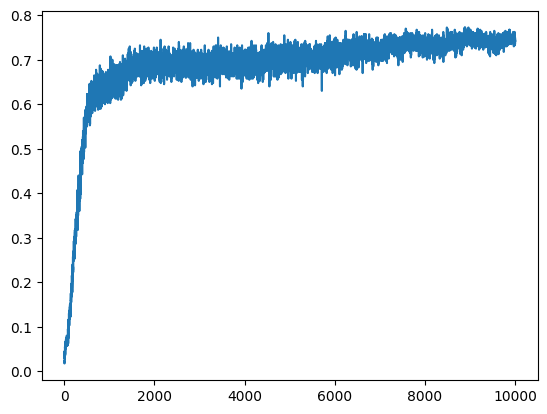

In [10]:
plt.plot(valid_acc)

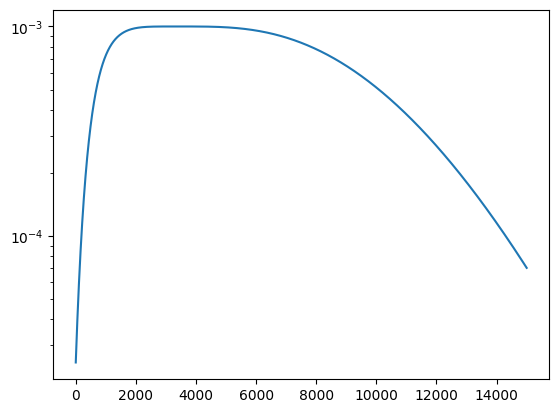

In [11]:
plt.semilogy(learning_rates)